[Caso Practico](https://drive.google.com/file/d/1yqHC3Sl0gMZZ9G0YjqGmUeddIHkeCS3u/view?usp=sharing)


*La empresa necesita saber a quién sería conveniente aceptarle el préstamo digitla, para así poder rentabilizar su capital y no tener problemas de morosidad.*

---

### Conexion Drive

In [42]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Anexos

In [43]:
! pip install woe

In [94]:
# Anexos : WOE
import woe
from woe.eval import plot_ks
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import warnings
warnings.filterwarnings('ignore')
max_bin = 20
force_bin = 3

In [96]:
# Anexos : WOE
import woe
from woe.eval import plot_ks
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import warnings
warnings.filterwarnings('ignore')
max_bin = 20
force_bin = 3


# Creamos las Woes - IV
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        #bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        bins = X.quantile(np.linspace(0, 1, force_bin)).values #creates a new binnning based on forced bins
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)})
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()

    return(d3)


def char_bin(Y, X):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return(d3)


def data_vars(df1, target):

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1

            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)

    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [45]:
# Funcion para dibujar el arbol (no esta de forma nativa en python)
import numpy as np
import pandas as pd
import graphviz, IPython
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.ticker import FuncFormatter
from sklearn.tree import export_graphviz

def draw_tree(tree, df):
    s = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True)
    return graphviz.Source(s)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

# Based on https://github.com/chrispaulca/waterfall.git
def waterfallplot(sample, data, Title="", x_lab="", y_lab="",
		 formatting="{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
		 sorted_value=False, threshold=None, other_label='other', net_label='net',
		 rotation_value=0, size=None):
	'''
	Given two sequences ordered appropriately, generate a standard waterfall chart.
	Optionally modify the title, axis labels, number formatting, bar colors,
	increment sorting, and thresholding. Thresholding groups lower magnitude changes
	into a combined group to display as a single entity on the chart.
	'''

	#convert data and index to np.array
	index = np.array([f'{c}\n({sample[c].iloc[0]})' for c in sample])
	data = np.array(data)

	# wip
	#sorted by absolute value
	if sorted_value:
		abs_data = abs(data)
		data_order = np.argsort(abs_data)[::-1]
		data = data[data_order]
		index = index[data_order]

	#group contributors less than the threshold into 'other'
	if threshold:

		abs_data = abs(data)
		threshold_v = abs_data.max()*threshold

		if threshold_v > abs_data.min():
			index = np.append(index[abs_data>=threshold_v],other_label)
			data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))

	changes = {'amount' : data}

	#define format formatter
	def money(x, pos):
		'The two args are the value and tick position'
		return formatting.format(x)
	formatter = FuncFormatter(money)

	fig, ax = plt.subplots(figsize=size)
	ax.yaxis.set_major_formatter(formatter)

	#Store data and create a blank series to use for the waterfall
	trans = pd.DataFrame(data=changes,index=index)
	blank = trans.amount.cumsum().shift(1).fillna(0)

	trans['positive'] = trans['amount'] > 0

	#Get the net total number for the final element in the waterfall
	total = trans.sum().amount
	trans.loc[net_label]= total
	blank.loc[net_label] = total

	#The steps graphically show the levels as well as used for label placement
	step = blank.reset_index(drop=True).repeat(3).shift(-1)
	step[1::3] = np.nan

	#When plotting the last element, we want to show the full bar,
	#Set the blank to 0
	blank.loc[net_label] = 0

	#define bar colors for net bar
	trans.loc[trans['positive'] > 1, 'positive'] = 99
	trans.loc[trans['positive'] < 0, 'positive'] = 99
	trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99

	trans['color'] = trans['positive']

	trans.loc[trans['positive'] == 1, 'color'] = green_color
	trans.loc[trans['positive'] == 0, 'color'] = red_color
	trans.loc[trans['positive'] == 99, 'color'] = blue_color

	my_colors = list(trans.color)

	#Plot and label
	my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color='white')
	plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
			 bottom=blank, color=my_colors)


	# connecting lines - figure out later
	#my_plot = lines.Line2D(step.index, step.values, color = "gray")
	#my_plot = lines.Line2D((3,3), (4,4))

	#axis labels
	plt.xlabel("\n" + x_lab)
	plt.ylabel(y_lab + "\n")

	#Get the y-axis position for the labels
	y_height = trans.amount.cumsum().shift(1).fillna(0)

	temp = list(trans.amount)

	# create dynamic chart range
	for i in range(len(temp)):
		if (i > 0) & (i < (len(temp) - 1)):
			temp[i] = temp[i] + temp[i-1]

	trans['temp'] = temp

	plot_max = trans['temp'].max()
	plot_min = trans['temp'].min()

	#Make sure the plot doesn't accidentally focus only on the changes in the data
	if all(i >= 0 for i in temp):
		plot_min = 0
	if all(i < 0 for i in temp):
		plot_max = 0

	if abs(plot_max) >= abs(plot_min):
		maxmax = abs(plot_max)
	else:
		maxmax = abs(plot_min)

	pos_offset = maxmax / 40

	plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

	#Start label loop
	loop = 0
	for index, row in trans.iterrows():
		# For the last item in the list, we don't want to double count
		if row['amount'] == total:
			y = y_height[loop]
		else:
			y = y_height[loop] + row['amount']
		# Determine if we want a neg or pos offset
		if row['amount'] > 0:
			y += (pos_offset*2)
			plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'g', fontsize=9)
		else:
			y -= (pos_offset*4)
			plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'r', fontsize=9)
		loop+=1

	#Scale up the y axis so there is room for the labels
	plt.ylim(plot_min-round(3.6*plot_offset, 7),plot_max+round(3.6*plot_offset, 7))

	#Rotate the labels
	plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)

	#add zero line and title
	plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
	plt.title(Title)
	plt.tight_layout()

	return plt

### Librerias

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Para los graficos tengan las mismas dimensiones
%matplotlib inline
plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (7, 4)

pd.options.display.max_columns = None
sns.set_style('whitegrid')
color = sns.color_palette()

## Rutas

In [48]:
#Repositorios
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
filename = "dataBasePrestDigital.csv"
fullpath = os.path.join(path, filename)

# Lectura de datos

In [49]:
df = pd.read_csv(fullpath,sep=";")

In [50]:
print(df.shape)
df.head(3)

(435083, 20)


,mes,cliente,estadoCliente,rngEdad,genero,rngSueldo,procedencia,operDigital,trxDigitalUm,promTrxDig3Um,recCamp,frecCamp,tenTarjeta,promConsBanco3Um,promSaldoBanco3Um,promSaldoTc3Um,promSaldoPrest3Um,sowTcUm,sowPrestUm,ventaPrestDig
0,201608,1,A,<35-45],M,<3500-4500],lima,NN,0,0.000000,1,3,TC-TD,5844.17,5844.17,5844.170000,0.0,1.0,0,0
1,201608,2,A,<25-35],M,<3500-4500],lima,BXI-BM,200,192.666667,1,3,TC-TD,0.00,0.00,2701.470000,0.0,0.0,0,0
2,201608,3,A,<35-45],F,<4500-6000],lima,BM,407,332.333333,1,3,TD,0.00,0.00,3148.746667,0.0,0.0,0,0


# Data Wrangling

In [51]:
df.columns

Index(['mes', 'cliente', 'estadoCliente', 'rngEdad', 'genero', 'rngSueldo',
       'procedencia', 'operDigital', 'trxDigitalUm', 'promTrxDig3Um',
       'recCamp', 'frecCamp', 'tenTarjeta', 'promConsBanco3Um',
       'promSaldoBanco3Um', 'promSaldoTc3Um', 'promSaldoPrest3Um', 'sowTcUm',
       'sowPrestUm', 'ventaPrestDig'],
      dtype='object')

In [52]:
df.dtypes

mes                    int64
cliente                int64
estadoCliente         object
rngEdad               object
genero                object
rngSueldo             object
procedencia           object
operDigital           object
trxDigitalUm           int64
promTrxDig3Um        float64
recCamp                int64
frecCamp               int64
tenTarjeta            object
promConsBanco3Um     float64
promSaldoBanco3Um    float64
promSaldoTc3Um       float64
promSaldoPrest3Um    float64
sowTcUm              float64
sowPrestUm             int64
ventaPrestDig          int64
dtype: object

In [53]:
ColumnsCategoricas = ['estadoCliente','rngEdad','genero','rngSueldo','procedencia','operDigital','tenTarjeta']
ColumnsNumericas =   ['trxDigitalUm','promTrxDig3Um','recCamp','frecCamp','promConsBanco3Um','promSaldoBanco3Um','promSaldoTc3Um','promSaldoPrest3Um','sowTcUm','sowPrestUm']

## Tratamiento de Nulos

In [54]:
df.isnull().sum().sort_values(ascending=False)

mes                  0
cliente              0
sowPrestUm           0
sowTcUm              0
promSaldoPrest3Um    0
promSaldoTc3Um       0
promSaldoBanco3Um    0
promConsBanco3Um     0
tenTarjeta           0
frecCamp             0
recCamp              0
promTrxDig3Um        0
trxDigitalUm         0
operDigital          0
procedencia          0
rngSueldo            0
genero               0
rngEdad              0
estadoCliente        0
ventaPrestDig        0
dtype: int64

In [55]:
df.isnull().sum()/df.shape[0]*100

mes                  0.0
cliente              0.0
estadoCliente        0.0
rngEdad              0.0
genero               0.0
rngSueldo            0.0
procedencia          0.0
operDigital          0.0
trxDigitalUm         0.0
promTrxDig3Um        0.0
recCamp              0.0
frecCamp             0.0
tenTarjeta           0.0
promConsBanco3Um     0.0
promSaldoBanco3Um    0.0
promSaldoTc3Um       0.0
promSaldoPrest3Um    0.0
sowTcUm              0.0
sowPrestUm           0.0
ventaPrestDig        0.0
dtype: float64

# **I. Analisis Exploratorio**

In [56]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mes,435083.0,NaN,NaN,NaN,201608.0,0.0,201608.0,201608.0,201608.0,201608.0,201608.0
cliente,435083.0,NaN,NaN,NaN,217542.0,125597.787922,1.0,108771.5,217542.0,326312.5,435083.0
estadoCliente,435083,3,A,391889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rngEdad,435083,5,<25-35],133586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genero,435083,2,M,244605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rngSueldo,435083,5,<1000-2500],186777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procedencia,435083,2,provincia,248070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operDigital,435083,4,NN,320549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trxDigitalUm,435083.0,NaN,NaN,NaN,42.601991,128.501383,0.0,0.0,0.0,9.0,8267.0
promTrxDig3Um,435083.0,NaN,NaN,NaN,39.123526,114.435858,0.0,0.0,0.0,12.666667,6291.333333


## Revision Objetivo

Porcentaje de Creditos Aprobados : 1.00
Porcentaje de Creditos Rechazados : 0.00


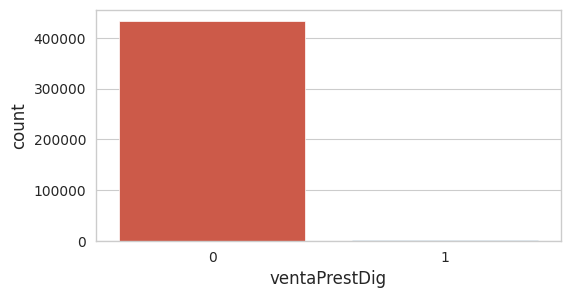

In [57]:
plt.figure(figsize=(6,3))
sns.countplot(x='ventaPrestDig', data=df);

print('Porcentaje de Creditos Aprobados : %.2f' % (df['ventaPrestDig'].value_counts()[0] / len(df)))
print('Porcentaje de Creditos Rechazados : %.2f' % (df['ventaPrestDig'].value_counts()[1] / len(df)))

In [58]:
# Vemos la distribucion del target!
df.ventaPrestDig.value_counts()/df.shape[0]*100

0    99.722812
1     0.277188
Name: ventaPrestDig, dtype: float64

* Vemos que la gente que compra representa el 0.27%

## Analisis Univariado

### Categoricas

estadoCliente
A    391889
I     42984
M       210
dtype: int64


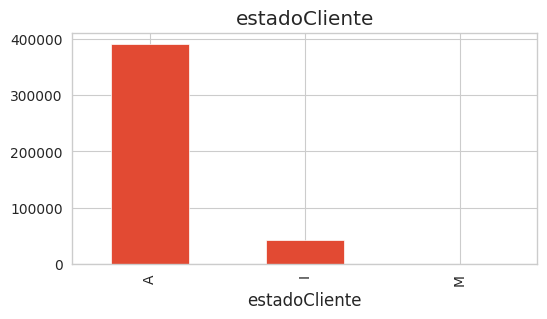

rngEdad
<25-35]    133586
<35-45]    133022
<45-55]     91640
<=25        18148
>55         58687
dtype: int64


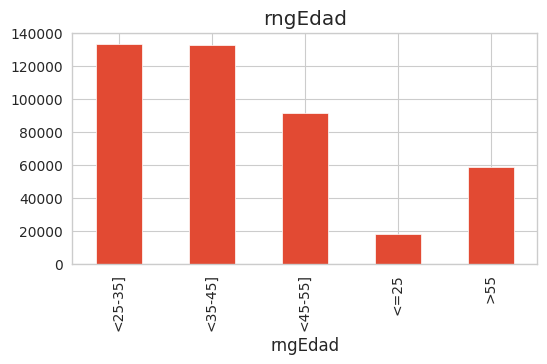

genero
F    190478
M    244605
dtype: int64


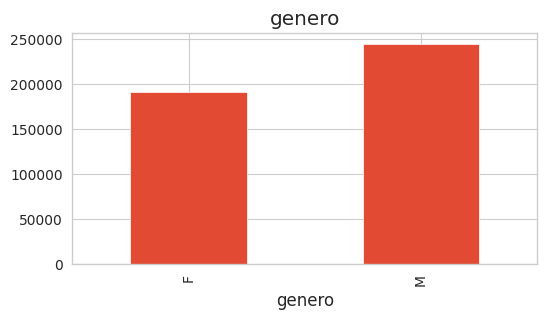

rngSueldo
<1000-2500]    186777
<3500-4500]     90686
<4500-6000]     36881
<=1000          65272
>6000           55467
dtype: int64


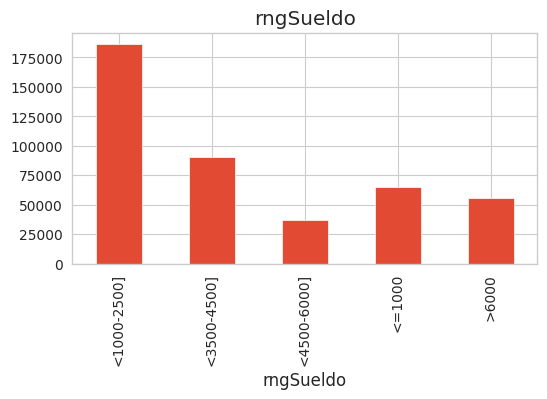

procedencia
lima         187013
provincia    248070
dtype: int64


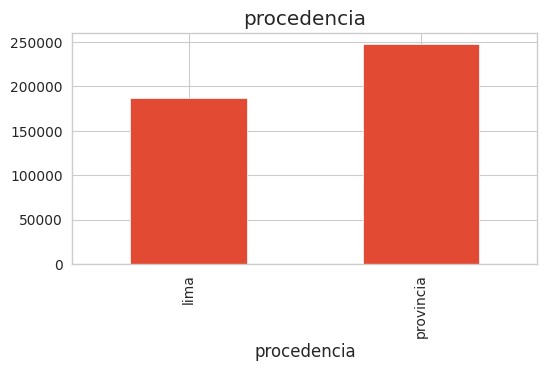

operDigital
BM         27003
BXI        58733
BXI-BM     28798
NN        320549
dtype: int64


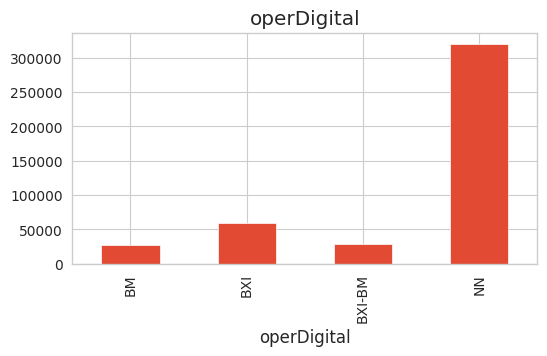

tenTarjeta
NN        85234
TC        21642
TC-TD    103441
TD       224766
dtype: int64


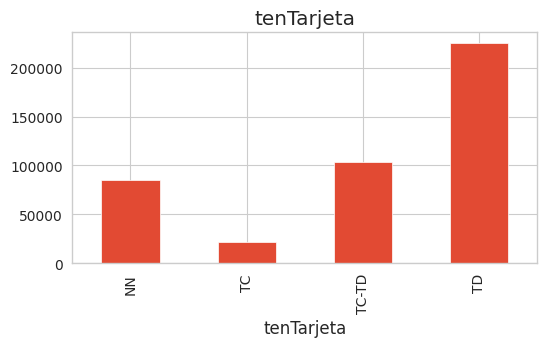

In [59]:
for x in ColumnsCategoricas:
  plt.figure(figsize=(6,3))
  print(df.groupby(x).size())
  plt.title(x)
  df.fillna("--NULL").groupby(x)[x].count().plot(kind = "bar")
  plt.show()

### Numericas

In [60]:
df[ColumnsNumericas].describe().T

,count,mean,std,min,25%,50%,75%,max
trxDigitalUm,435083.0,42.601991,128.501383,0.0,0.0,0.000000,9.000000,8267.000000
promTrxDig3Um,435083.0,39.123526,114.435858,0.0,0.0,0.000000,12.666667,6291.333333
recCamp,435083.0,16.935153,36.090774,1.0,1.0,1.000000,1.000000,99.000000
frecCamp,435083.0,1.936840,1.149609,0.0,1.0,2.000000,3.000000,3.000000
promConsBanco3Um,435083.0,822.585136,4619.738770,0.0,0.0,0.000000,0.000000,280967.576700
promSaldoBanco3Um,435083.0,491.166213,2532.848787,0.0,0.0,0.000000,0.000000,153971.113300
promSaldoTc3Um,435083.0,2002.220798,5144.381844,0.0,0.0,232.333333,1836.060000,173735.230000
promSaldoPrest3Um,435083.0,1665.058009,7763.036612,0.0,0.0,0.000000,0.000000,628000.000000
sowTcUm,435083.0,0.105745,0.290548,0.0,0.0,0.000000,0.000000,1.000000
sowPrestUm,435083.0,0.000002,0.001516,0.0,0.0,0.000000,0.000000,1.000000


In [61]:
df.groupby('ventaPrestDig').median() # Mediana no se ve afectada con valores atípicos

,mes,cliente,trxDigitalUm,promTrxDig3Um,recCamp,frecCamp,promConsBanco3Um,promSaldoBanco3Um,promSaldoTc3Um,promSaldoPrest3Um,sowTcUm,sowPrestUm
ventaPrestDig,,,,,,,,,,,,
0,201608.0,217382.0,0.0,0.000000,1.0,2.0,0.0,0.0,231.123333,0.0,0.0,0.0
1,201608.0,249817.0,128.0,110.833333,1.0,1.0,0.0,0.0,1074.020000,0.0,0.0,0.0


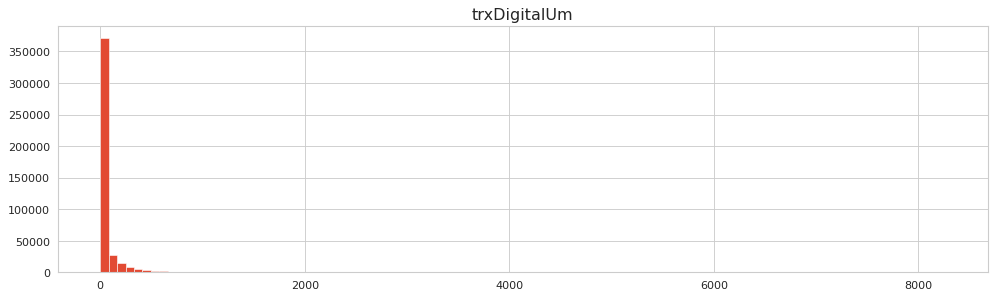

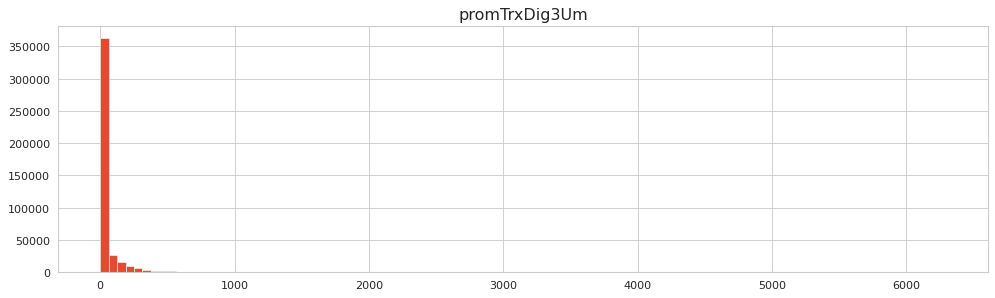

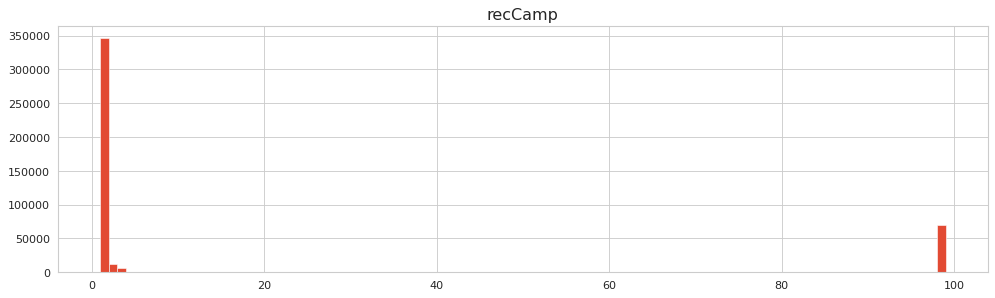

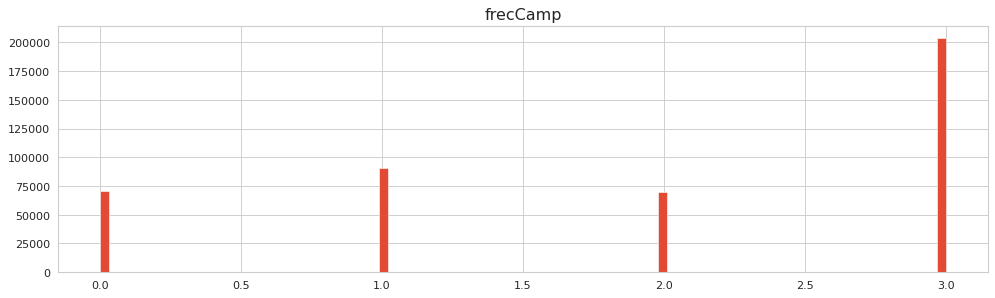

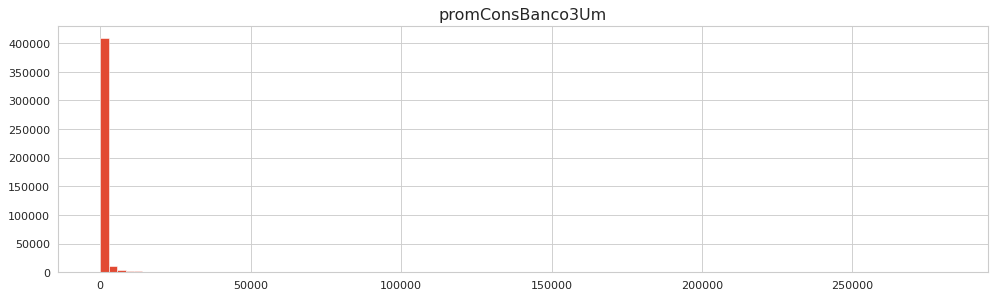

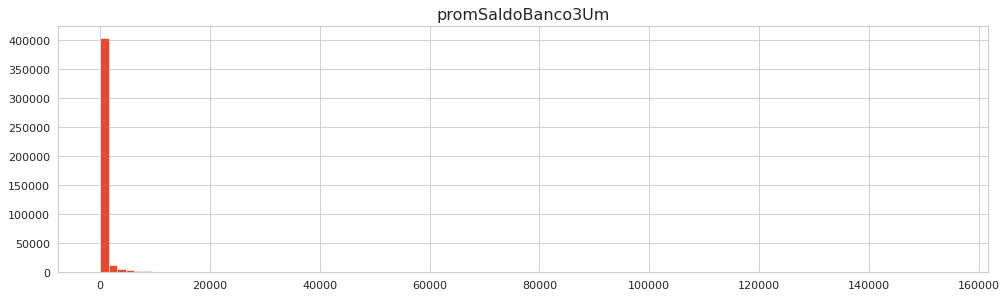

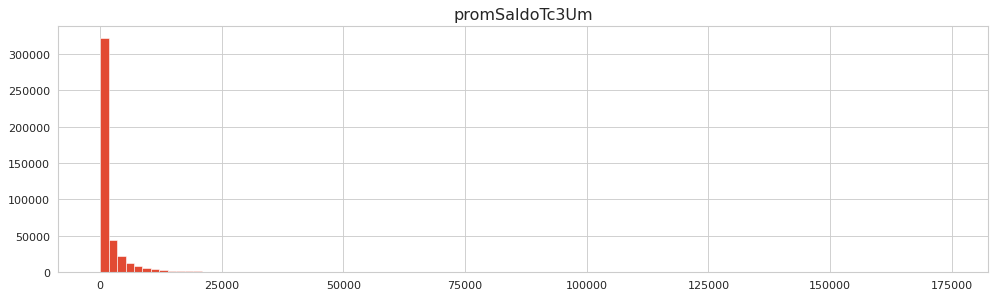

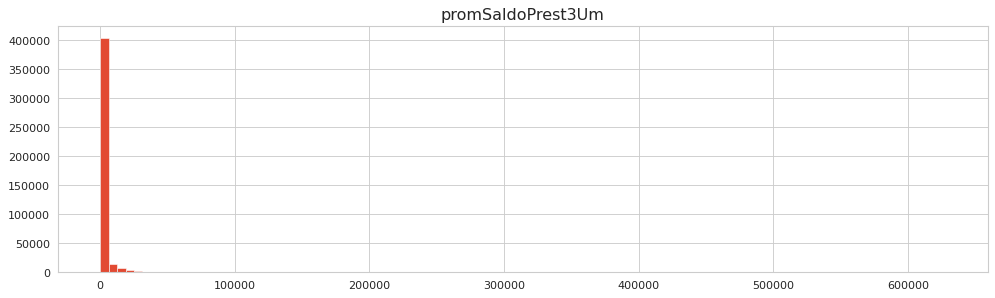

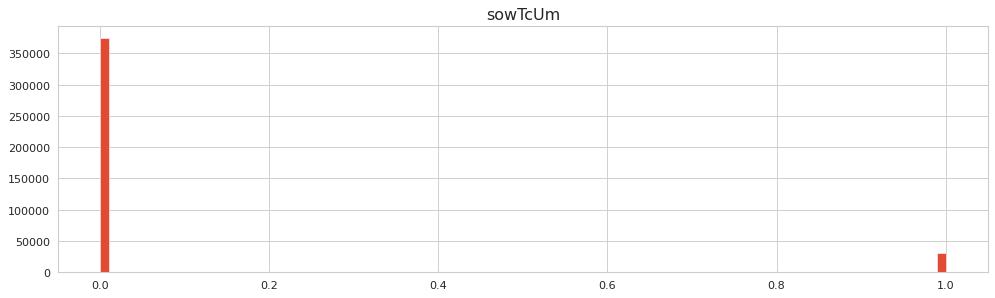

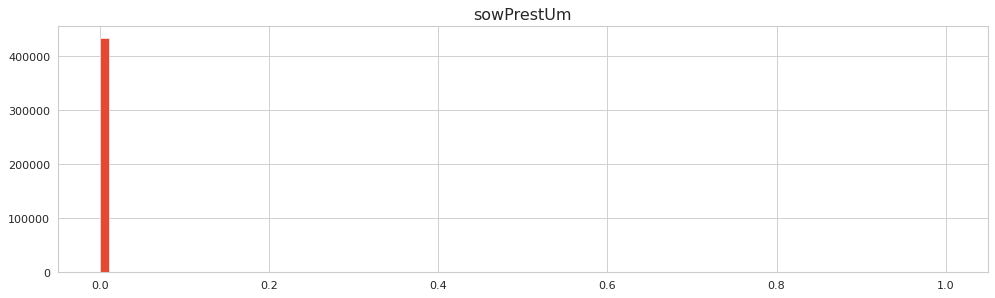

In [62]:
for x in ColumnsNumericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  plt.hist(df[x],bins=100)
  plt.show()

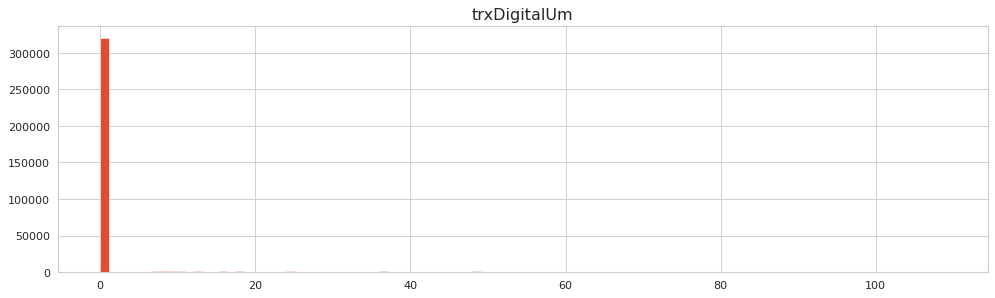

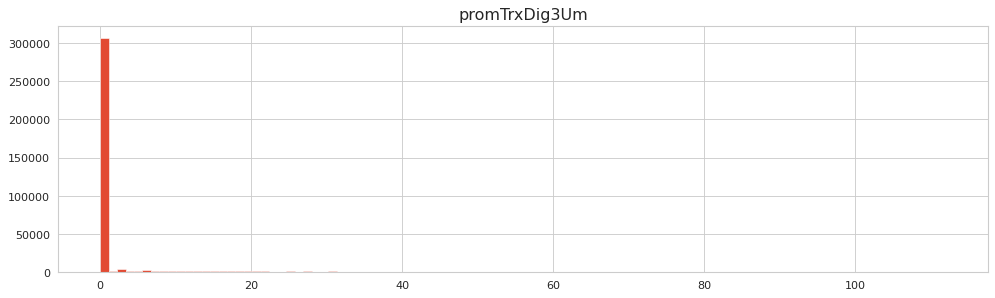

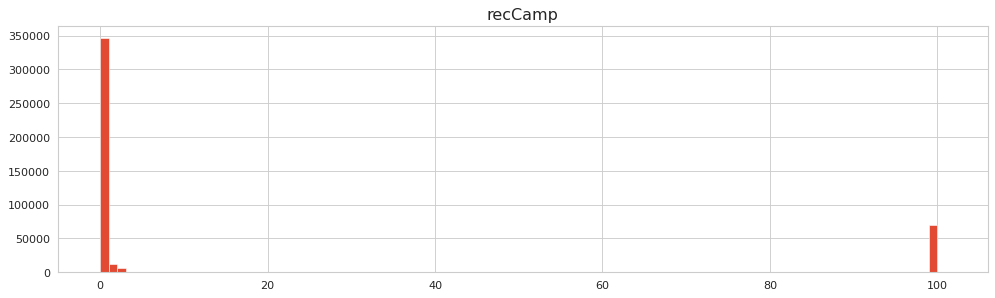

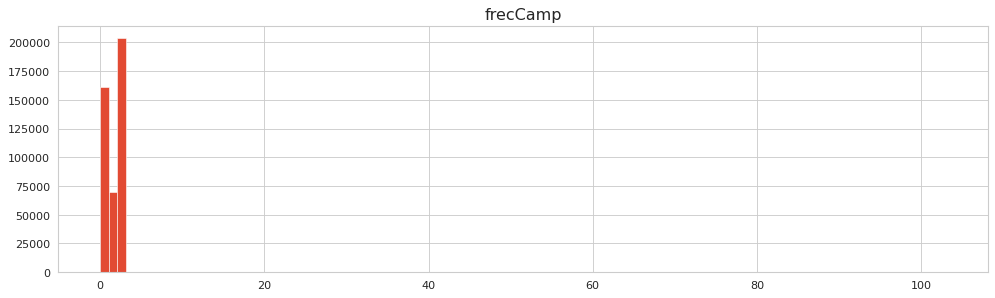

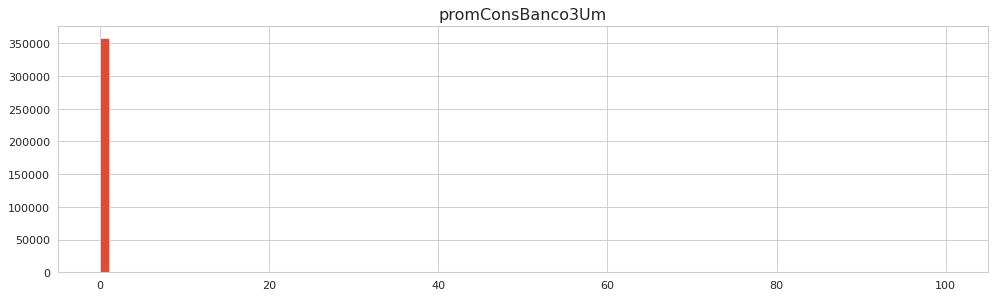

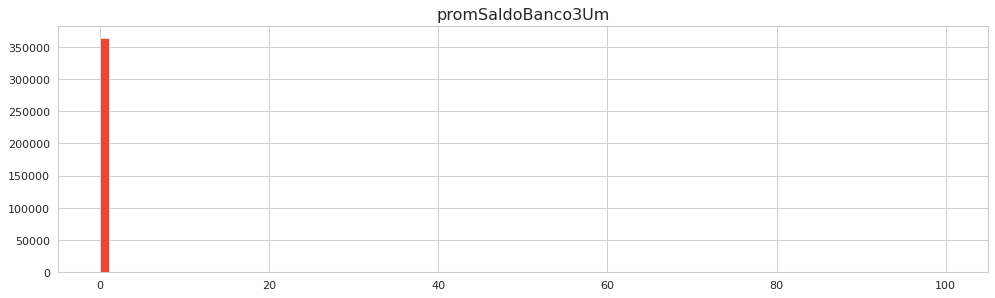

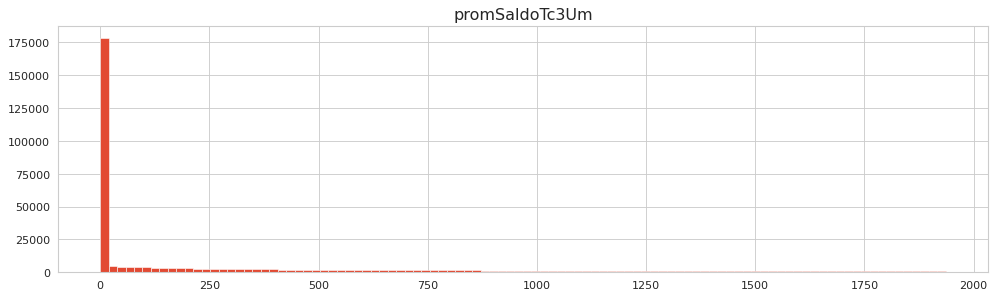

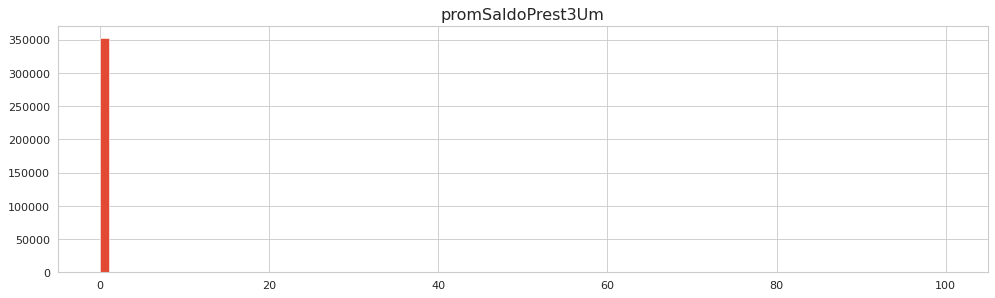

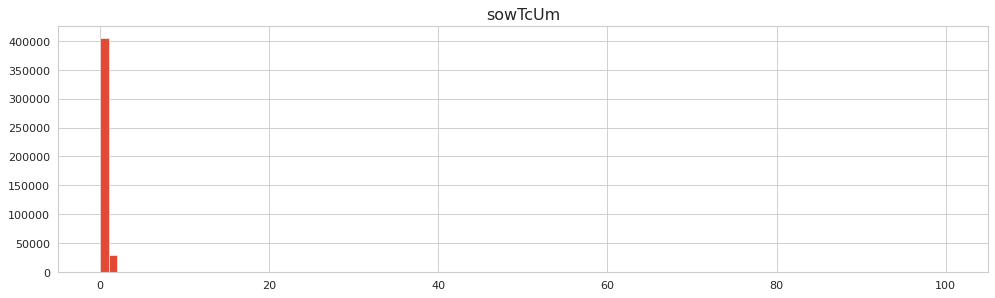

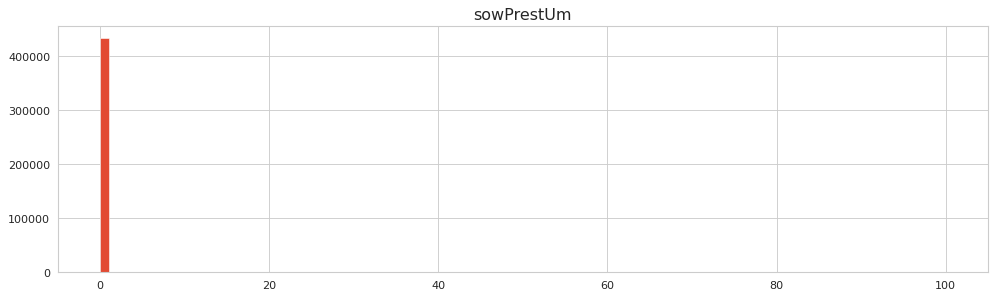

In [63]:
# No consideramos las colas (outliers) para ver mejor la distribucion
for x in ColumnsNumericas:
  plt.figure(figsize=(15,4), dpi=80)
  Q03= int(df[x].quantile(0.75))+100
  plt.title(df[x].name)
  plt.hist(df[x],bins=100,range=(0,Q03))
  plt.show()

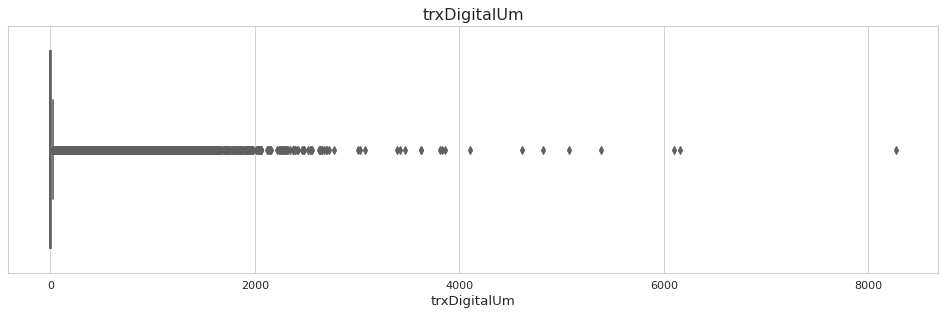

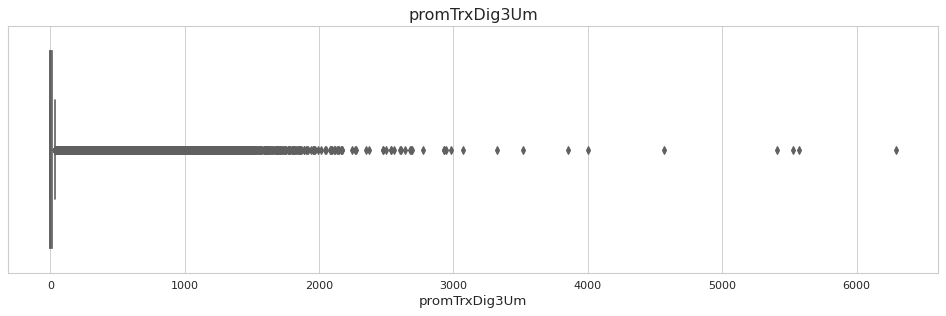

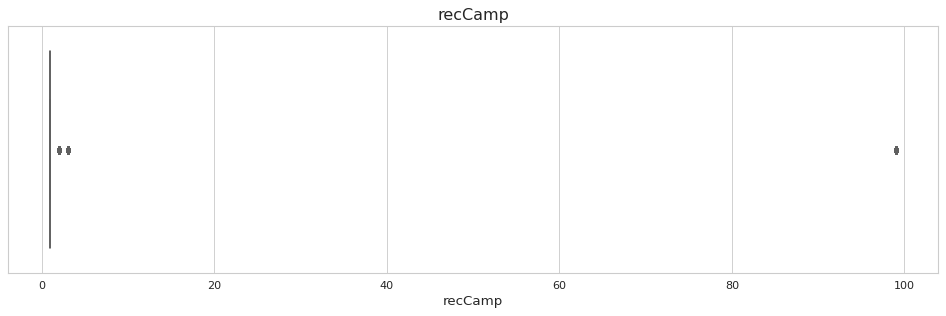

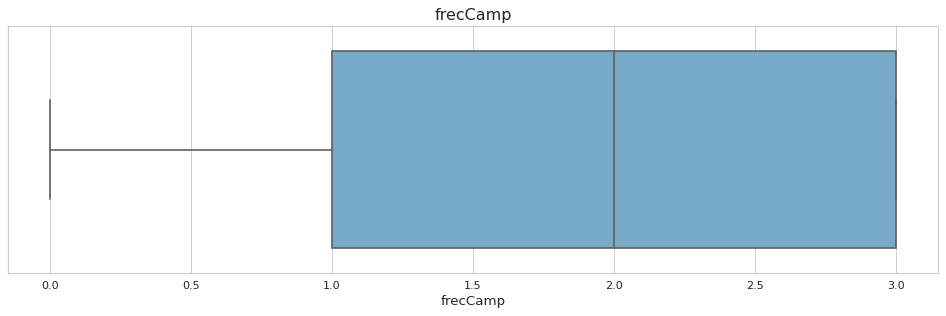

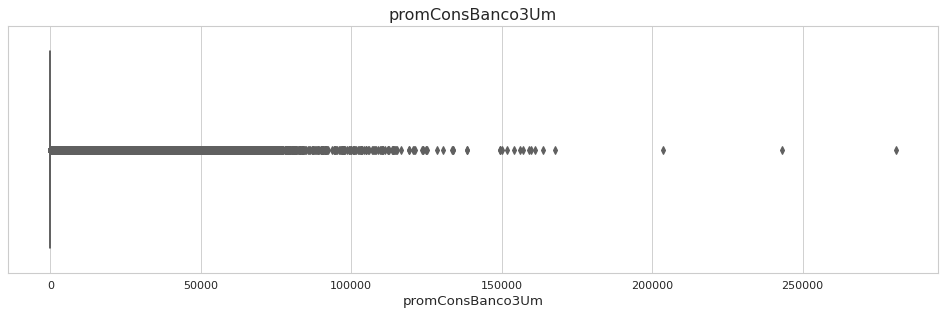

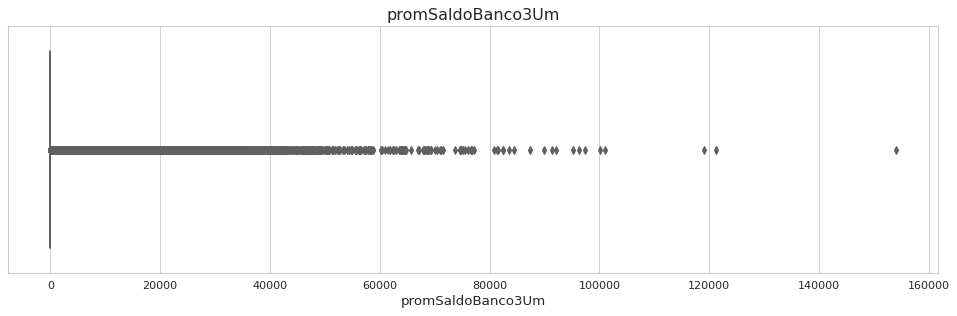

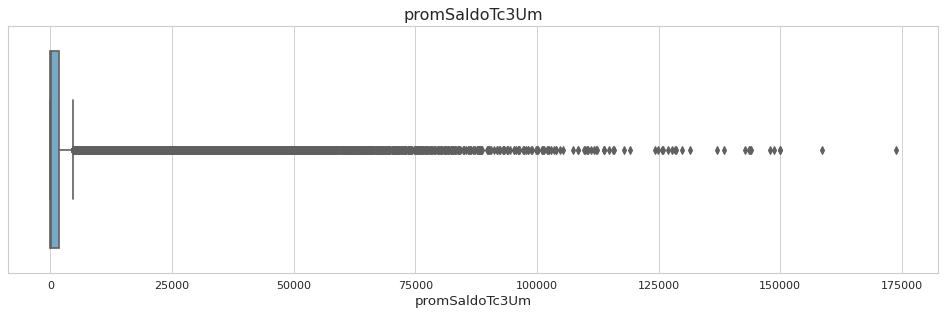

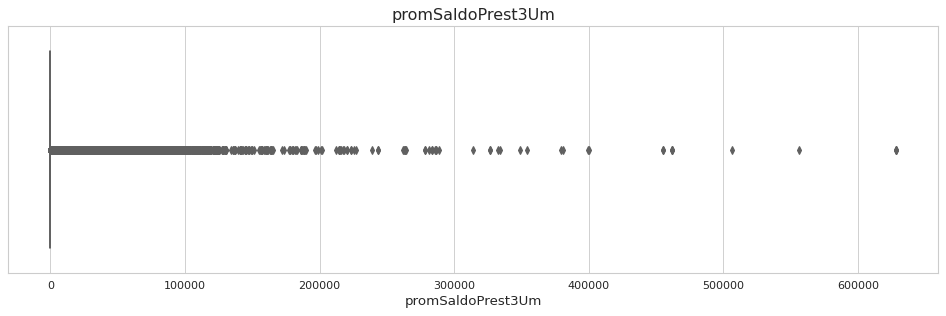

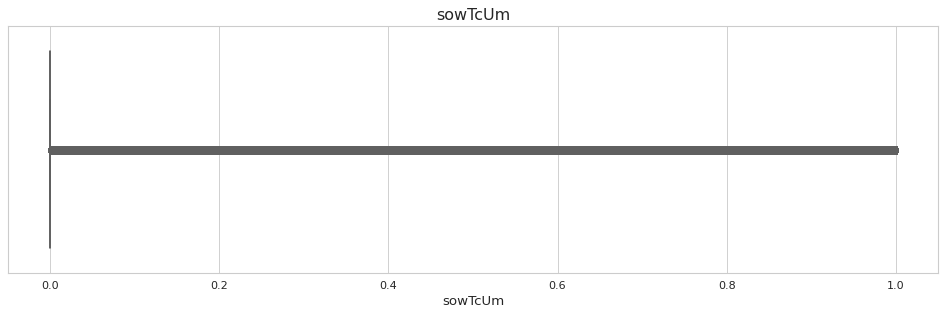

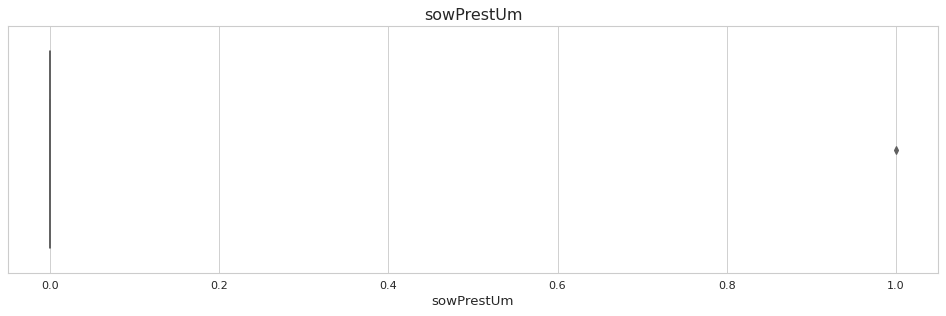

In [64]:
# Grafico de Cajas para revision de atipicos
for x in ColumnsNumericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues")
  plt.show()

## Anlisis Bivariado

### Categoricas

In [65]:
ColumnsCategoricas

['estadoCliente',
 'rngEdad',
 'genero',
 'rngSueldo',
 'procedencia',
 'operDigital',
 'tenTarjeta']

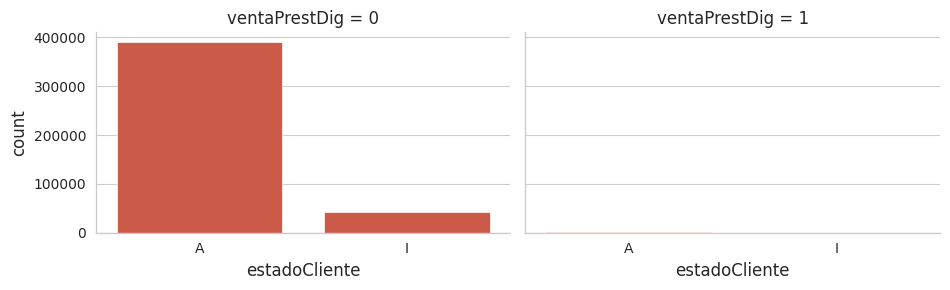

In [66]:
# estadoCliente

grid = sns.FacetGrid(df,col='ventaPrestDig', aspect=1.6)
grid.map(sns.countplot, 'estadoCliente');

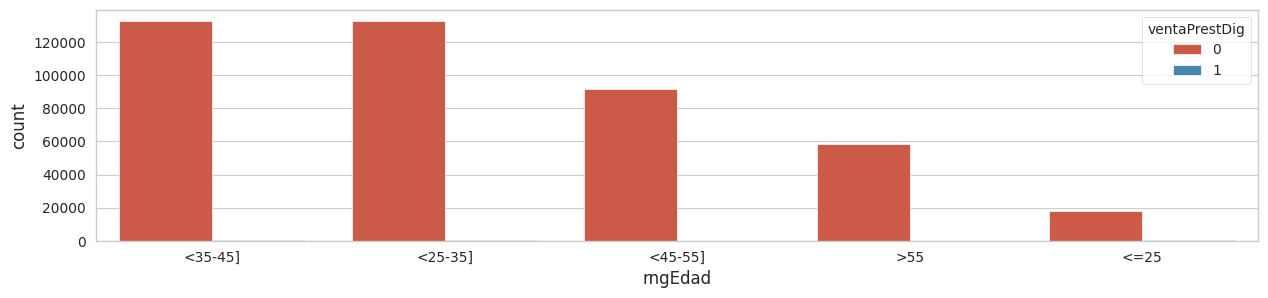

In [67]:
# rngEdad

plt.figure(figsize=(15,3))
sns.countplot(x='rngEdad', hue='ventaPrestDig', data=df);

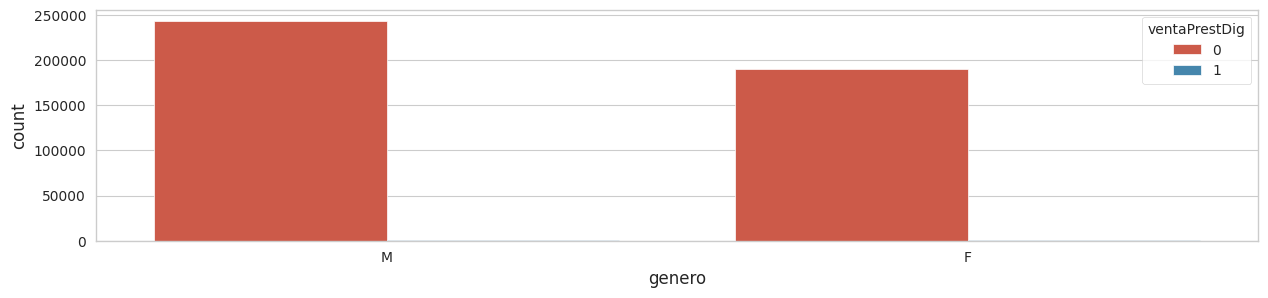

In [68]:
# genero

plt.figure(figsize=(15,3))
sns.countplot(x='genero', hue='ventaPrestDig', data=df);

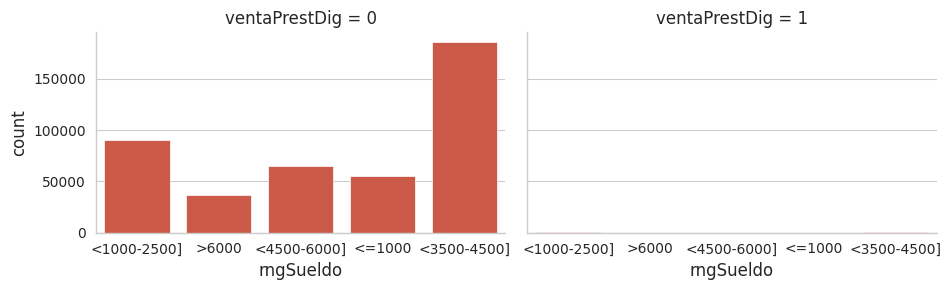

In [69]:
# rngSueldo

grid = sns.FacetGrid(df,col='ventaPrestDig', aspect=1.6)
grid.map(sns.countplot, 'rngSueldo');

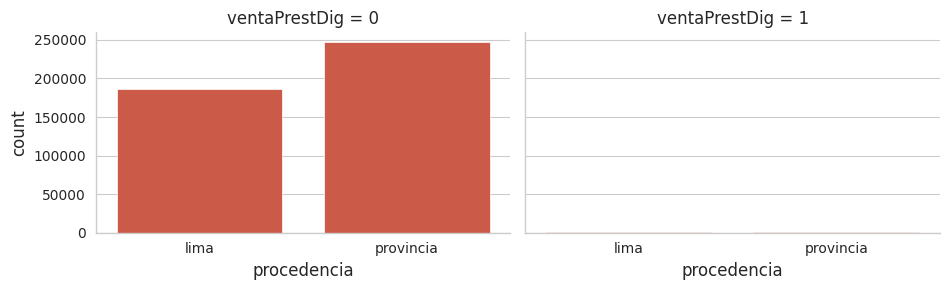

In [70]:
# procedencia

grid = sns.FacetGrid(df,col='ventaPrestDig', aspect=1.6)
grid.map(sns.countplot, 'procedencia');

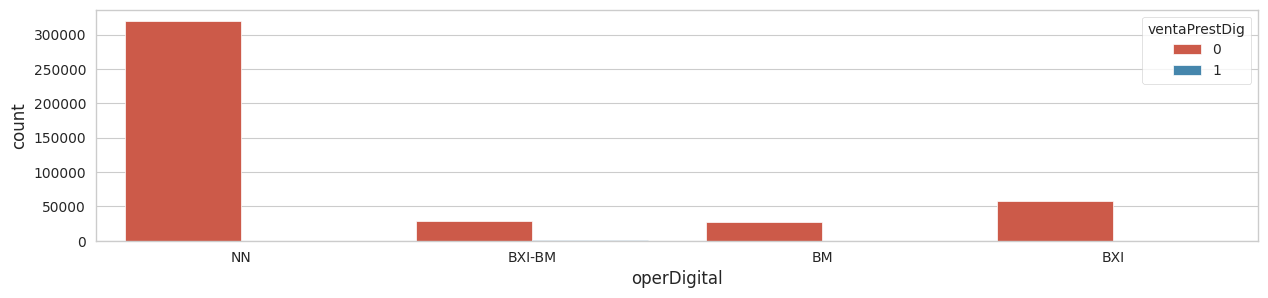

In [71]:
# genero

plt.figure(figsize=(15,3))
sns.countplot(x='operDigital', hue='ventaPrestDig', data=df);

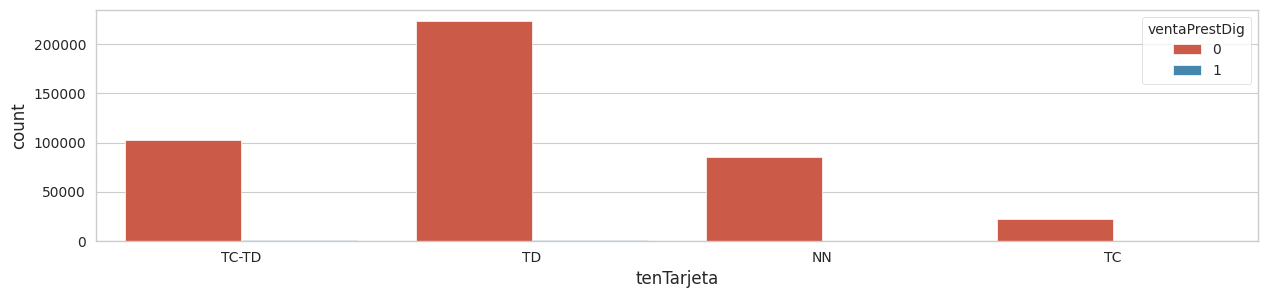

In [72]:
# tenTarjeta

plt.figure(figsize=(15,3))
sns.countplot(x='tenTarjeta', hue='ventaPrestDig', data=df);

### Numericas

trxDigitalUm


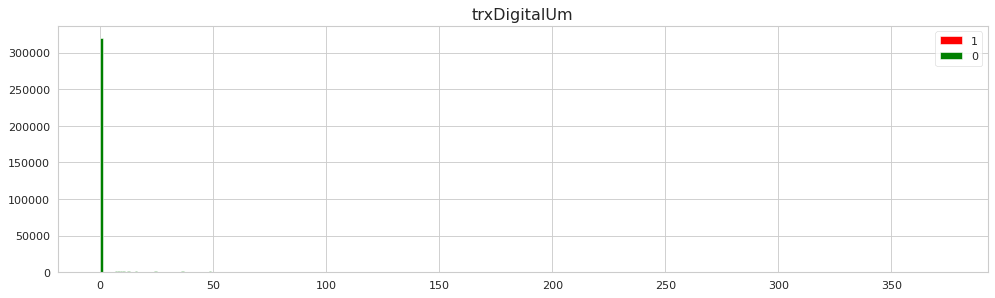

promTrxDig3Um


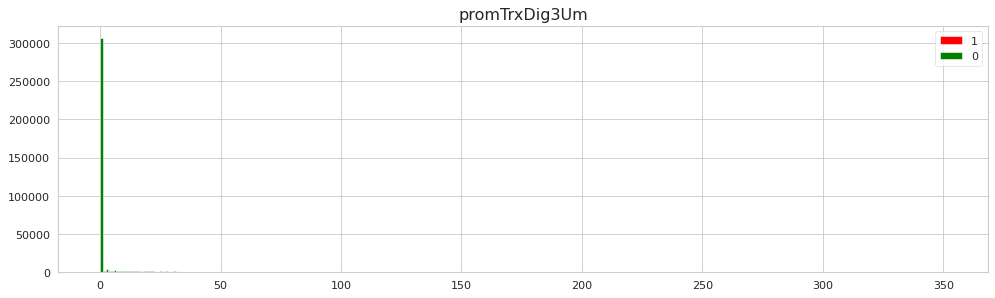

recCamp


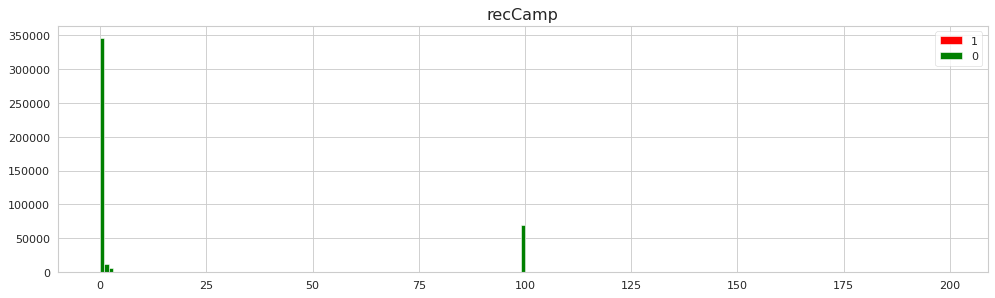

frecCamp


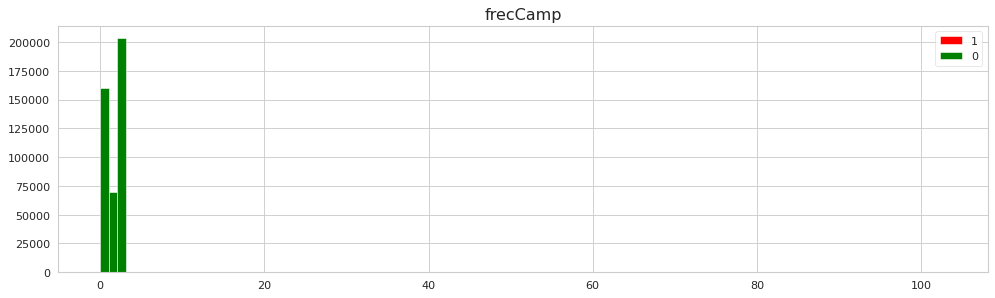

promConsBanco3Um


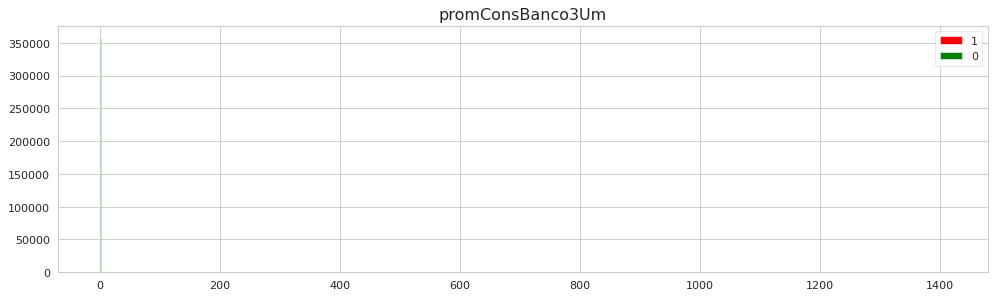

promSaldoBanco3Um


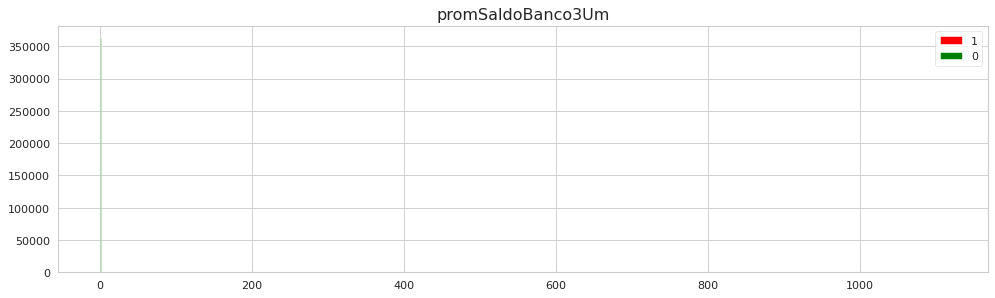

promSaldoTc3Um


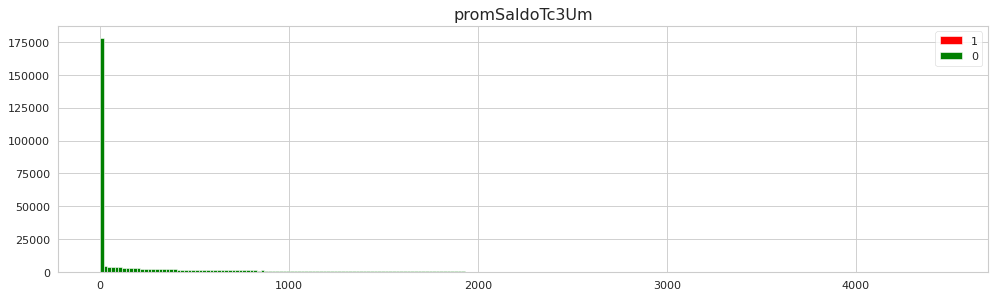

promSaldoPrest3Um


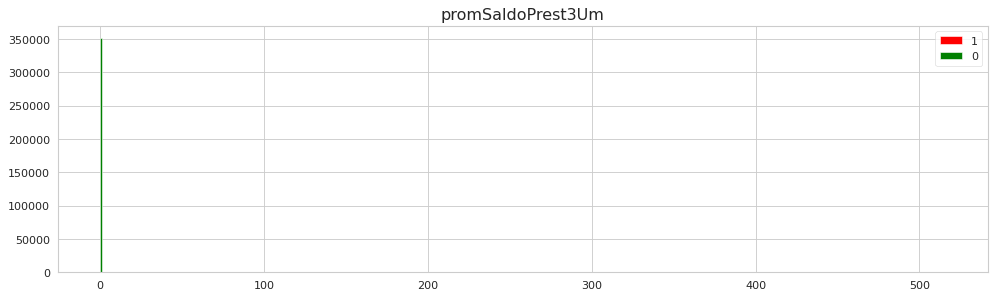

sowTcUm


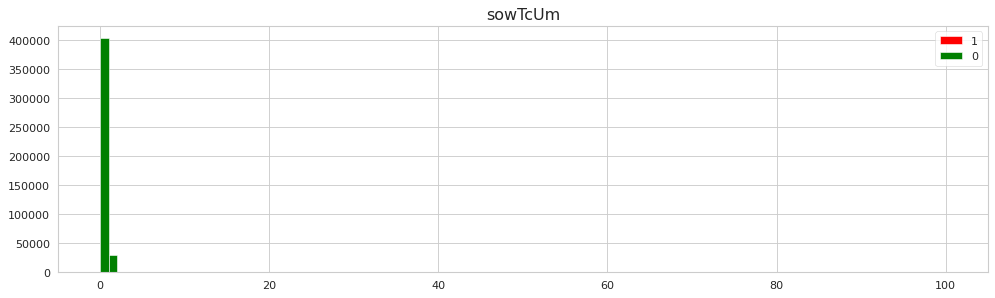

sowPrestUm


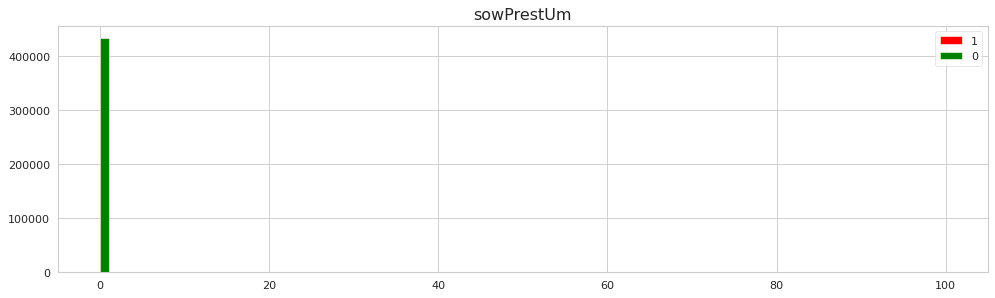

In [73]:
# Analizando variables numericas con respecto al target
for x in ColumnsNumericas:
  print(x)
  plt.figure(figsize=(15,4), dpi=80)
  x1 = df.loc[df['ventaPrestDig']==1,x]  #Serie
  x2 = df.loc[df['ventaPrestDig']==0,x]  #serie

  Q03x1 = int(pd.DataFrame(x1)[x].quantile(0.75))+100  # Q3 de la serie
  Q03x2 = int(pd.DataFrame(x2)[x].quantile(0.75))+100  # Q3 de la serie

  #se muestran las densidades
  plt.title(df[x].name)
  plt.hist(x1,bins=100,color='r',range=(0,Q03x1),label=1)
  plt.hist(x2,bins=100,color='g',range=(0,Q03x2),label=0)
  plt.legend()
  plt.show()

In [74]:
df_prub = df.copy()
df_prub['ventaPrestDig_LB'] = np.where(df_prub['ventaPrestDig']==0,'N','Y')

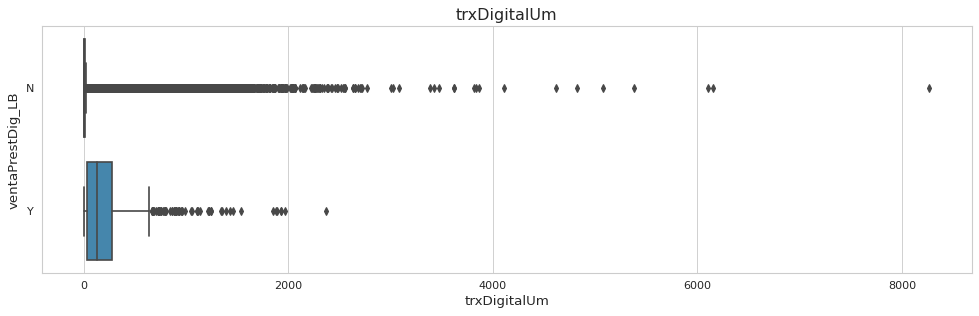

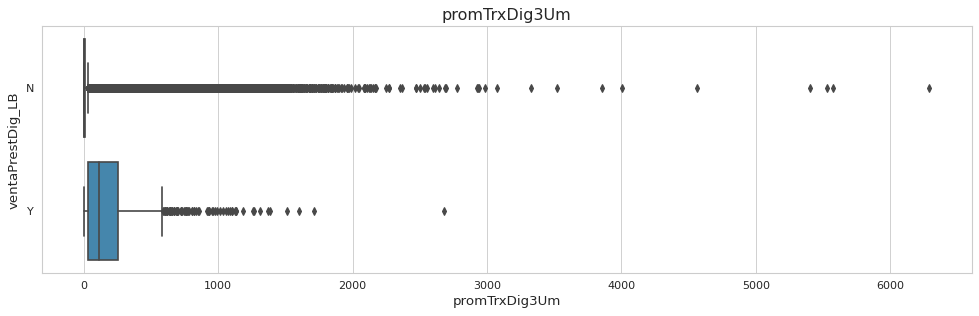

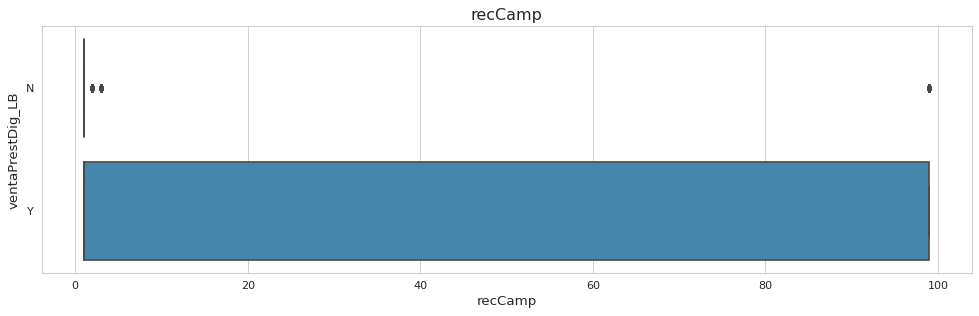

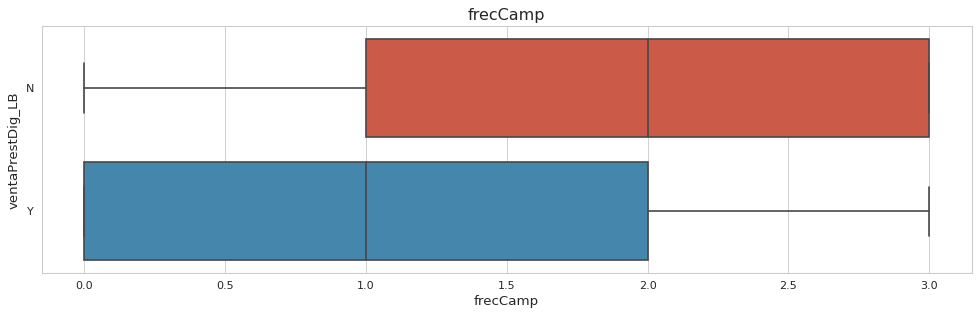

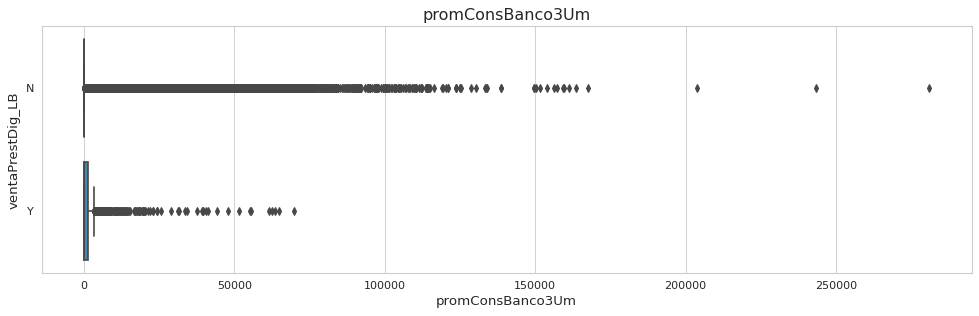

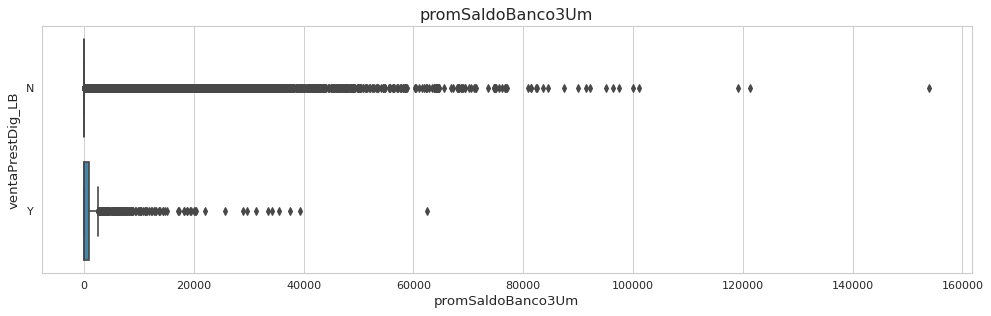

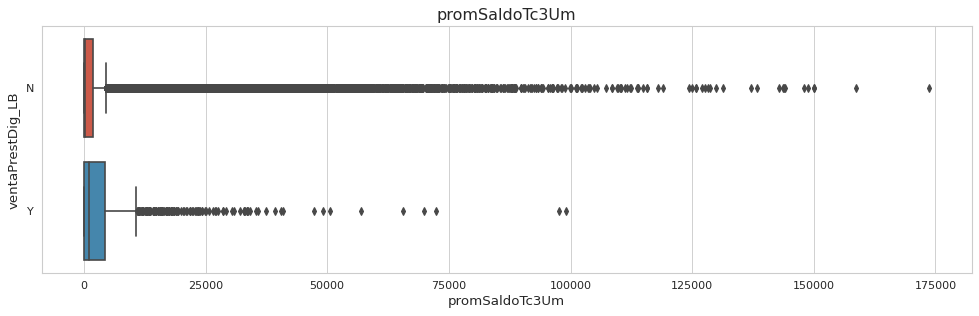

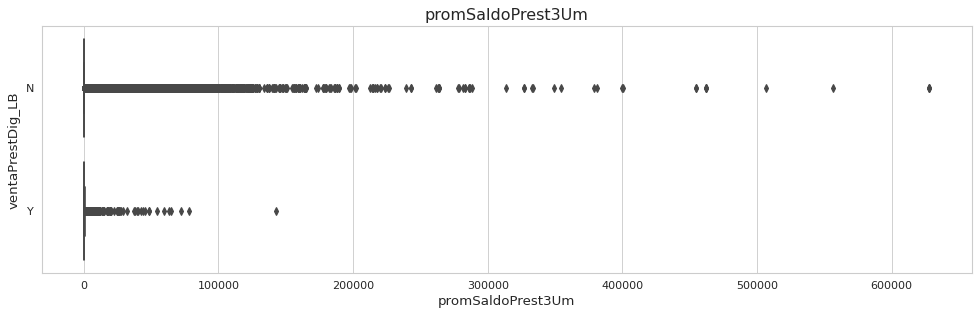

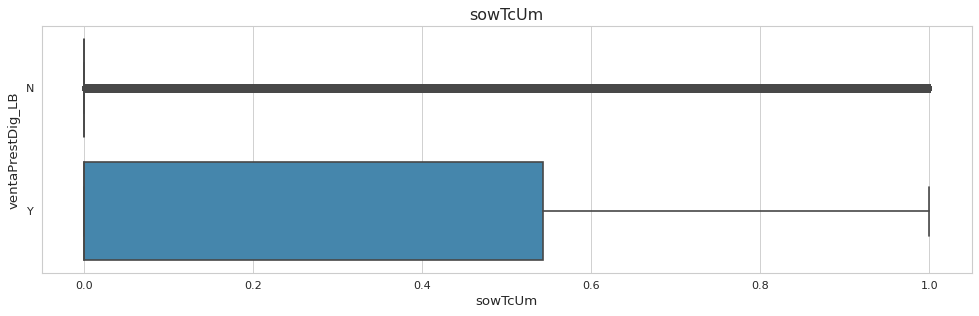

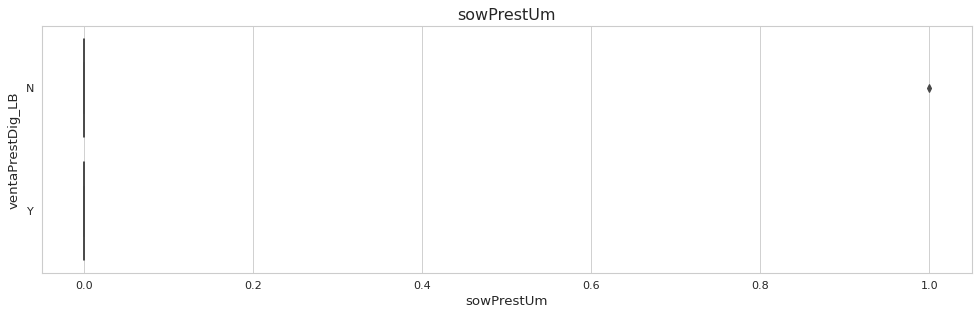

In [75]:
# Grafico de cajas respecto al target
for x in ColumnsNumericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df_prub[x].name)
  sns.boxplot(x=df_prub[x],y=df_prub['ventaPrestDig_LB'])
  plt.show()

## Analisis Multivariado

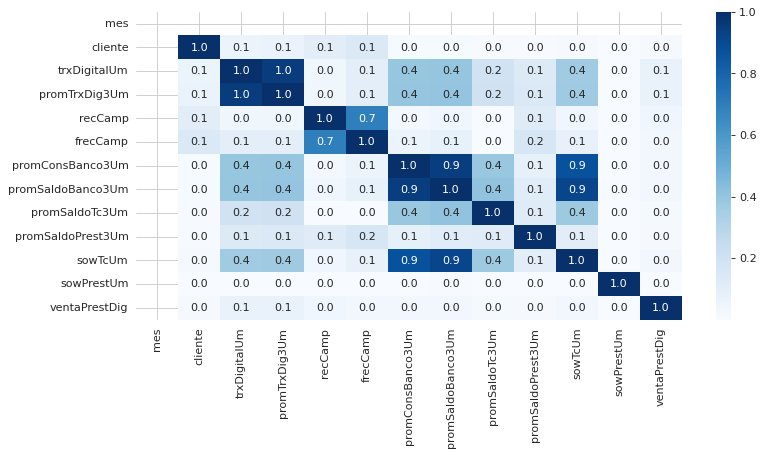

In [76]:
# Analizamos la correlacion de las variables
# Spearman: Para variables numericas. No asume normalidad
plt.figure(figsize=(11,5), dpi=80)
sns.heatmap(abs(df.corr(method='spearman')),annot=True,fmt='.1f',cmap='Blues')
plt.show()

# **II. Recodificacion Data**

In [79]:
# Creamos 2 dataset de variables categoricas!
df_categoricas_01 = df[ColumnsCategoricas]
df_categoricas_02 = df[ColumnsCategoricas]

## LabelEncoder

In [77]:
from sklearn.preprocessing import LabelEncoder

In [80]:
for c in df_categoricas_01:
    print(str(c))
    le = LabelEncoder()
    le.fit(df_categoricas_01[str(c)])
    df_categoricas_01[str(c)]=le.transform(df_categoricas_01[str(c)])

estadoCliente
rngEdad
genero
rngSueldo
procedencia
operDigital
tenTarjeta


In [85]:
print(df_categoricas_01.shape)
df_categoricas_01.head(3)

(435083, 7)


,estadoCliente,rngEdad,genero,rngSueldo,procedencia,operDigital,tenTarjeta
0,0,1,1,1,0,3,2
1,0,0,1,1,0,2,2
2,0,1,0,2,0,0,3


## OneHotEncoder

In [82]:
# Preprocesamiento con OneHotEncoder
df_categoricas_03 = pd.get_dummies(df_categoricas_02)

In [84]:
print(df_categoricas_03.shape)
df_categoricas_03.head(3)

(435083, 25)


,estadoCliente_A,estadoCliente_I,estadoCliente_M,rngEdad_<25-35],rngEdad_<35-45],rngEdad_<45-55],rngEdad_<=25,rngEdad_>55,genero_F,genero_M,rngSueldo_<1000-2500],rngSueldo_<3500-4500],rngSueldo_<4500-6000],rngSueldo_<=1000,rngSueldo_>6000,procedencia_lima,procedencia_provincia,operDigital_BM,operDigital_BXI,operDigital_BXI-BM,operDigital_NN,tenTarjeta_NN,tenTarjeta_TC,tenTarjeta_TC-TD,tenTarjeta_TD
0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1


## Juntar Bases

In [86]:
df2 = pd.concat([df[ColumnsNumericas],df_categoricas_01,df.ventaPrestDig],axis=1)

# **III. Ingenieria de Variables**

In [87]:
df2['promConsSaldoBanco3Um']        =  df2['promConsBanco3Um'] / (df2['promSaldoBanco3Um'] +1)
df2['promSaldoCampanas']            = df2['promConsBanco3Um']  / (df2['frecCamp']+1)
df2['promSaldoTc3UmIngreso']        = df2['promSaldoTc3Um']    / (df2['rngSueldo']+1)
df2['log_promTrxDig3Um']            =  np.log1p(df2['promTrxDig3Um']+1)
df2['desv_trxDigi_3m']              = (df2.trxDigitalUm - df2.promTrxDig3Um)/(df2.promTrxDig3Um + 1) # Variacion
df2['prod_rec_frec']                = df2.recCamp * df2.frecCamp                               # Interacciones
df2['frecCamp_2']                   = np.power(df2.frecCamp,2)

In [88]:
print(df2.shape)
df2.head(3)

(435083, 25)


,trxDigitalUm,promTrxDig3Um,recCamp,frecCamp,promConsBanco3Um,promSaldoBanco3Um,promSaldoTc3Um,promSaldoPrest3Um,sowTcUm,sowPrestUm,estadoCliente,rngEdad,genero,rngSueldo,procedencia,operDigital,tenTarjeta,ventaPrestDig,promConsSaldoBanco3Um,promSaldoCampanas,promSaldoTc3UmIngreso,log_promTrxDig3Um,desv_trxDigi_3m,prod_rec_frec,frecCamp_2
0,0,0.000000,1,3,5844.17,5844.17,5844.170000,0.0,1.0,0,0,1,1,1,0,3,2,0,0.999829,1461.0425,2922.085000,0.693147,0.000000,3,9
1,200,192.666667,1,3,0.00,0.00,2701.470000,0.0,0.0,0,0,0,1,1,0,2,2,0,0.000000,0.0000,1350.735000,5.271289,0.037866,3,9
2,407,332.333333,1,3,0.00,0.00,3148.746667,0.0,0.0,0,0,1,0,2,0,0,3,0,0.000000,0.0000,1049.582222,5.812138,0.224000,3,9


## PolynomialFeatures

[Polinomical Features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [89]:
# Ingenieria de Variables con Features polinómicos!
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias= False) # Definimos el grado del polinomio
to_cross = ['promTrxDig3Um', 'promConsBanco3Um', 'promSaldoBanco3Um']          # Definimos las variables con las que queremos jugar!

crossed_feats = poly.fit_transform(df2[to_cross].values)                       # Aplicamos la transformacion polinomica.

# Guardamos los nuevos features en un dataframe
crossed_feats = pd.DataFrame(crossed_feats) # Revision de las nuevas variables que se crean!
crossed_feats.head(4)

,0,1,2,3,4,5,6,7,8
0,0.000000,5844.17,5844.17,0.000000,0.0,0.0,3.415432e+07,3.415432e+07,3.415432e+07
1,192.666667,0.00,0.00,37120.444457,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,332.333333,0.00,0.00,110445.444422,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,67.67,67.67,0.000000,0.0,0.0,4.579229e+03,4.579229e+03,4.579229e+03


**Entendemos lo necesario a extraer!**
* Logica: 1,2,3,1^2,1*2,1*3,2^2,2*3,3^2
* Las primeras tres variables [0:2] son las variables originales
* de las variables [3:9] son variables nuevas (la cuarta variable es la primera al cuadrado, la quinta es la pruimera por la segunda, etc)
*  1,2,3,    1^2,1*2,1*3,2^2,2*3,3^2

In [90]:
crossed_feats = pd.DataFrame(crossed_feats.iloc[:,3:9].to_numpy(),columns=['promTrxDig3Um_2','promTrxDig3Um_promConsBanco3Um','promTrxDig3Um_promSaldoBanco3Um','promConsBanco3Um_2','promConsBanco3Um_promSaldoBanco3Um','promSaldoBanco3Um_2'])
crossed_feats.head(4)

,promTrxDig3Um_2,promTrxDig3Um_promConsBanco3Um,promTrxDig3Um_promSaldoBanco3Um,promConsBanco3Um_2,promConsBanco3Um_promSaldoBanco3Um,promSaldoBanco3Um_2
0,0.000000,0.0,0.0,3.415432e+07,3.415432e+07,3.415432e+07
1,37120.444457,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,110445.444422,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.0,0.0,4.579229e+03,4.579229e+03,4.579229e+03


In [92]:
# Concatenamos la informacion!
df3 = pd.concat([df2,crossed_feats],axis=1)
print(df3.shape)
df3.head(3)

(435083, 31)


,trxDigitalUm,promTrxDig3Um,recCamp,frecCamp,promConsBanco3Um,promSaldoBanco3Um,promSaldoTc3Um,promSaldoPrest3Um,sowTcUm,sowPrestUm,estadoCliente,rngEdad,genero,rngSueldo,procedencia,operDigital,tenTarjeta,ventaPrestDig,promConsSaldoBanco3Um,promSaldoCampanas,promSaldoTc3UmIngreso,log_promTrxDig3Um,desv_trxDigi_3m,prod_rec_frec,frecCamp_2,promTrxDig3Um_2,promTrxDig3Um_promConsBanco3Um,promTrxDig3Um_promSaldoBanco3Um,promConsBanco3Um_2,promConsBanco3Um_promSaldoBanco3Um,promSaldoBanco3Um_2
0,0,0.000000,1,3,5844.17,5844.17,5844.170000,0.0,1.0,0,0,1,1,1,0,3,2,0,0.999829,1461.0425,2922.085000,0.693147,0.000000,3,9,0.000000,0.0,0.0,3.415432e+07,3.415432e+07,3.415432e+07
1,200,192.666667,1,3,0.00,0.00,2701.470000,0.0,0.0,0,0,0,1,1,0,2,2,0,0.000000,0.0000,1350.735000,5.271289,0.037866,3,9,37120.444457,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,407,332.333333,1,3,0.00,0.00,3148.746667,0.0,0.0,0,0,1,0,2,0,0,3,0,0.000000,0.0000,1049.582222,5.812138,0.224000,3,9,110445.444422,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00


# **IV. Seleccion de variables**

## Woes

In [97]:
# Selección por WOESS!
final_iv, IV = data_vars(df3,df3.ventaPrestDig)
IV.sort_values('IV',ascending=False)

,VAR_NAME,IV
20,promTrxDig3Um_2,1.567889e+00
19,promTrxDig3Um,1.567889e+00
5,log_promTrxDig3Um,1.562976e+00
29,trxDigitalUm,1.432419e+00
28,tenTarjeta,6.059407e-01
0,desv_trxDigi_3m,5.645323e-01
6,operDigital,4.572440e-01
21,promTrxDig3Um_promConsBanco3Um,4.529478e-01
22,promTrxDig3Um_promSaldoBanco3Um,3.999043e-01
23,recCamp,3.568408e-01


## Random Forest

In [98]:
# Podemos para ser ordenados, separar las covariables del target!
x= df3.drop('ventaPrestDig',axis=1)  # Features
y= df3.ventaPrestDig                 # Target

In [99]:
# Seleccion por Random Forest
from sklearn.ensemble import RandomForestClassifier # Paso01: Instancio el algoritmo
forest = RandomForestClassifier()                   # Paso02: Configuro el algoritmo
forest.fit(x,y)                                     # Paso03: Ajuste o entrenamiento el algoritmo
importances = forest.feature_importances_           # Paso04: Variables importantes

In [100]:
# Seleccion por Random Forest
TablaImportancia = pd.concat([pd.DataFrame({'Driver':list(x.columns)}),
                              pd.DataFrame({'Importancia':list(forest.feature_importances_)})], axis = 1)
ImportanciaVariables = TablaImportancia[['Driver','Importancia']].sort_values('Importancia', ascending = False).reset_index(drop = True)
ImportanciaVariables

,Driver,Importancia
0,promSaldoTc3UmIngreso,0.087509
1,promSaldoTc3Um,0.087300
2,desv_trxDigi_3m,0.085890
3,log_promTrxDig3Um,0.078706
4,promTrxDig3Um,0.076247
5,promTrxDig3Um_2,0.074661
6,trxDigitalUm,0.071456
7,promSaldoPrest3Um,0.066890
8,promConsSaldoBanco3Um,0.028332
9,promConsBanco3Um_2,0.028206


# **V. Modelado**

In [101]:
# Separación de predictoras y predicha
X = df3.drop('ventaPrestDig',axis=1) # Features o Covariables.
y = df3.ventaPrestDig                # Target u Objetivo

## Particion Muestral

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X,  # Covariables
                                                    y,  # Target
                                                    test_size=0.33, # % test
                                                    stratify=y,     # Estratificar!
                                                    random_state=2021)

In [104]:
# Distribucion real del target!
df3.ventaPrestDig.value_counts()/df3.shape[0]*100

0    99.722812
1     0.277188
Name: ventaPrestDig, dtype: float64

In [105]:
# Distribucion del target de entrenamiento!
y_train.value_counts()/y_train.shape[0]*100

0    99.722818
1     0.277182
Name: ventaPrestDig, dtype: float64

In [106]:
# Distribucion del target de prueba!
y_test.value_counts()/y_test.shape[0]*100

0    99.722799
1     0.277201
Name: ventaPrestDig, dtype: float64

## Arbol Clasificacion

In [107]:
from sklearn.tree import DecisionTreeClassifier

In [108]:
# Arbol Basico
tree_complete=DecisionTreeClassifier()

# Arbol Experto
tree_expert=DecisionTreeClassifier(ccp_alpha=0.0,
                            class_weight=None,
                            criterion='gini',
                            max_depth=7,
                            max_features=10,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            #min_impurity_split=None,
                            min_samples_leaf=50,
                            min_samples_split=100,
                            min_weight_fraction_leaf=0.0,
                            #presort='deprecated',
                            random_state=None,
                            splitter='best')

# Arbol Sencillo
tree_bonsai=DecisionTreeClassifier(ccp_alpha=0.0,
                            class_weight=None,
                            criterion='gini',
                            max_depth=2,
                            max_features=3,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            #min_impurity_split=None,
                            min_samples_leaf=10000,
                            min_samples_split=20000,
                            min_weight_fraction_leaf=0.0,
                            #presort='deprecated',
                            random_state=None,
                            splitter='best')

In [109]:
# Entrenamos!
tree_model_c = tree_complete.fit(X_train,y_train)
tree_model_e = tree_expert.fit(X_train,y_train)
tree_model_b = tree_bonsai.fit(X_train,y_train)

In [110]:
# Predecimos!
Y_pred_c = tree_model_c.predict(X_test)
Y_pred_e = tree_model_e.predict(X_test)
Y_pred_b = tree_model_b.predict(X_test)

### Evaluacion

In [112]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [113]:
#Cálculo del accuracy
ac_c=accuracy_score(Y_pred_c,y_test)
ac_e=accuracy_score(Y_pred_e,y_test)
ac_b=accuracy_score(Y_pred_b,y_test)

In [114]:
print('Arbol completo y sin conocimiento de parametros: ',ac_c)
print('Arbol experto y con conocimiento de parametros: ',ac_e)
print('Arbol muy reducido: ',ac_b)

Arbol completo y sin conocimiento de parametros:  0.9943097131872571
Arbol experto y con conocimiento de parametros:  0.9972279875746981
Arbol muy reducido:  0.9972279875746981


In [115]:
#Matriz de confusión
conf_mat_c = confusion_matrix(y_test,Y_pred_c)
conf_mat_e = confusion_matrix(y_test,Y_pred_e)
conf_mat_b = confusion_matrix(y_test,Y_pred_b)

In [117]:
print('Arbol completo y sin conocimiento de parametros:\n',conf_mat_c)
print('Arbol experto y con conocimiento de parametros:\n',conf_mat_e)
print('Arbol muy reducido:\n',conf_mat_b)

Arbol completo y sin conocimiento de parametros:
 [[142748    432]
 [   385     13]]
Arbol experto y con conocimiento de parametros:
 [[143180      0]
 [   398      0]]
Arbol muy reducido:
 [[143180      0]
 [   398      0]]


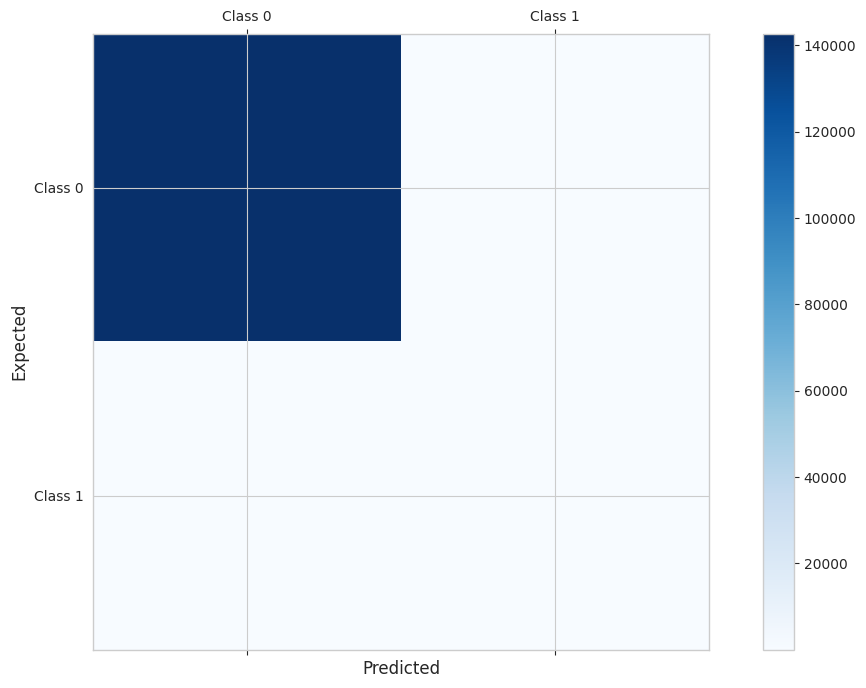

In [118]:
# Visualizando la matriz de confusión
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_c, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

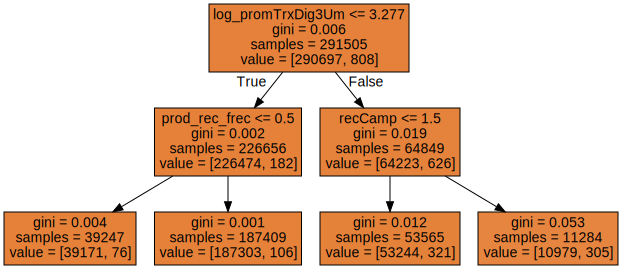

In [119]:
# Visualizando el arbol!
# Muy estable pero poco preciso
draw_tree(tree_bonsai, x)

In [120]:
# Visualizando el arbol!
draw_tree(tree_complete, x)

Output hidden; open in https://colab.research.google.com to view.

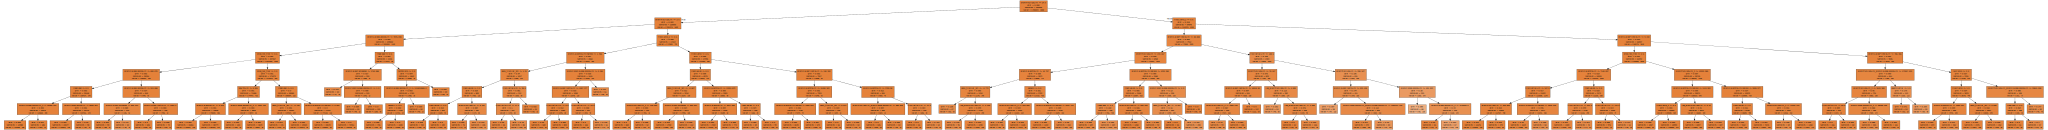

In [121]:
# Visualizando el arbol!
draw_tree(tree_expert, x)

# **VI. Balanceo de Muestras**

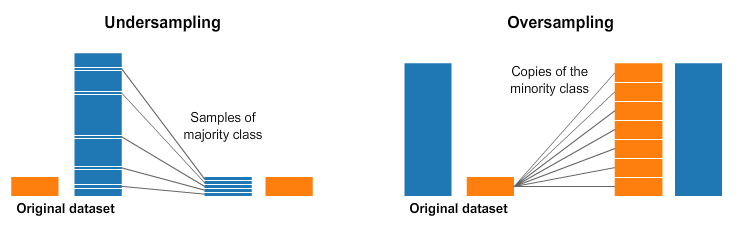

In [122]:
df3.ventaPrestDig.value_counts()/df3.shape[0]*100

0    99.722812
1     0.277188
Name: ventaPrestDig, dtype: float64

In [123]:
# Conteo de clases, de 0's y de 1's
count_class_0, count_class_1 = df3.ventaPrestDig.value_counts()

In [124]:
# Dividiendo el set de datos en 2 partes!
df_class_0 = df3[df3['ventaPrestDig'] == 0]
df_class_1 = df3[df3['ventaPrestDig'] == 1]

In [125]:
print('Cantidades por fila de clase:')
print(df_class_0.shape)
print(df_class_1.shape)

Cantidades por fila de clase:
(433877, 31)
(1206, 31)


## Random under-sampling (Submuestreo aleatorio)

In [126]:
# del dataframe enorme tomamos una muestra aleatoria
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under,df_class_1],axis = 0)

In [127]:
print('Dimensión por tipo de clases generadas:')
print('dim df_class_0_under:',df_class_0_under.shape)
print('dim df_class_1:',df_class_1.shape)
print('dim df_under:',df_under.shape)

Dimensión por tipo de clases generadas:
dim df_class_0_under: (1206, 31)
dim df_class_1: (1206, 31)
dim df_under: (2412, 31)


In [128]:
print('Random under-sampling:')
print(df_under.ventaPrestDig.value_counts())

Random under-sampling:
0    1206
1    1206
Name: ventaPrestDig, dtype: int64


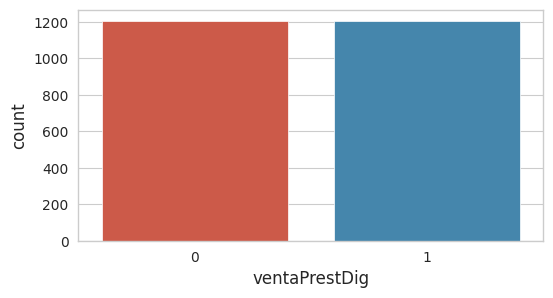

In [129]:
plt.figure(figsize=(6,3))
sns.countplot(x='ventaPrestDig', data=df_under);

In [130]:
print(df_under.shape)
df_under.head(4)

(2412, 31)


,trxDigitalUm,promTrxDig3Um,recCamp,frecCamp,promConsBanco3Um,promSaldoBanco3Um,promSaldoTc3Um,promSaldoPrest3Um,sowTcUm,sowPrestUm,estadoCliente,rngEdad,genero,rngSueldo,procedencia,operDigital,tenTarjeta,ventaPrestDig,promConsSaldoBanco3Um,promSaldoCampanas,promSaldoTc3UmIngreso,log_promTrxDig3Um,desv_trxDigi_3m,prod_rec_frec,frecCamp_2,promTrxDig3Um_2,promTrxDig3Um_promConsBanco3Um,promTrxDig3Um_promSaldoBanco3Um,promConsBanco3Um_2,promConsBanco3Um_promSaldoBanco3Um,promSaldoBanco3Um_2
418272,0,0.000000,99,0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,1,1,3,2,0,0.0,0.0,0.000000,0.693147,0.000000,0,0,0.000000,0.0,0.0,0.0,0.0,0.0
157603,0,0.000000,1,3,0.0,0.0,0.000000,0.0,0.0,0,0,4,1,0,1,3,1,0,0.0,0.0,0.000000,0.693147,0.000000,3,9,0.000000,0.0,0.0,0.0,0.0,0.0
38574,32,39.333333,99,0,0.0,0.0,2377.836667,0.0,0.0,0,0,1,0,2,0,1,3,0,0.0,0.0,792.612222,3.721669,-0.181818,0,0,1547.111111,0.0,0.0,0.0,0.0,0.0
143457,0,0.000000,1,2,0.0,0.0,2673.560000,0.0,0.0,0,0,2,1,0,1,3,3,0,0.0,0.0,2673.560000,0.693147,0.000000,2,4,0.000000,0.0,0.0,0.0,0.0,0.0


**Probando la predicción con data balanceada**

In [131]:
X_train = df_under.drop( 'ventaPrestDig',axis=1)
y_train = df_under['ventaPrestDig']

In [132]:
tree_model_2 = tree_complete.fit(X_train,y_train)

In [133]:
# Predecimos!
Y_pred_train_under = tree_model_2.predict(X_train)
Y_pred_test_under = tree_model_2.predict(X_test) # realizando la predicción

In [134]:
from sklearn import metrics as metrics

In [139]:
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,Y_pred_train_under)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,Y_pred_test_under)
print(cm_test)
print('\n')

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,Y_pred_train_under)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,Y_pred_test_under)
print(accuracy_test)
print('\n')

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,Y_pred_train_under)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,Y_pred_test_under)
print(precision_test)
print('\n')

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,Y_pred_train_under)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,Y_pred_test_under)
print(recall_test)

Matriz confusion: Train
[[1204    2]
 [  20 1186]]
Matriz confusion: Test
[[104546  38634]
 [     8    390]]


Accuracy: Train
0.9908789386401327
Accuracy: Test
0.7308640599534748


Precision: Train
0.9983164983164983
Precision: Test
0.009993849938499385


Recall: Train
0.9834162520729685
Recall: Test
0.9798994974874372


* Vemos que la matriz del test para los 1 es mejor (su sensibilidad ha mejorado), pero al igualar, se equivoca ahora en 34k en los 0.
* Mejoramos en la minoritaria, pero debemos identificar bien a LA VENTA (o la que hace DEFAULT)
* Vamos a tener mucho falso negativo